#### I. Import library and generate dataset

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn import hmm
from sklearn.utils import check_random_state
import collections

In [3]:
# Generate dataset

model = hmm.GaussianHMM(n_components = 4, init_params="")
model.n_features = 1
model.startprob_ = np.array([0.35, 0.3, 0.22, 0.13])
model.transmat_ = np.array([[0.4, 0.3, 0.2, 0.1],
                            [0.3, 0.4, 0.2, 0.1],
                            [0.2, 0.3, 0.4, 0.1],
                            [0.1, 0.2, 0.3, 0.4]])
model.means_ = np.array([[200000],
                        [800000],
                        [1000000],
                        [3000000]])
model.covars_ = np.array([[70000],
                          [210000],
                          [300000],
                          [1000000]])
X_train = []
lengths_train = []
X_val = []
lengths_val = []
X_validate = []
lengths_validate = []
X_test = []
lengths_test = []
for i in range(0,100):
# Generate X_train
    X,_ = model.sample(n_samples = np.random.randint(low = 30, high = 50))
    X_train.extend(X)
    lengths_train.append(len(X))
X_train = np.array(X_train)
# Generate X_val
for i in range(0,100):
    X,_ = model.sample(n_samples = np.random.randint(low = 30, high = 50))
    X_val.extend(X)
    lengths_val.append(len(X))
X_val = np.array(X_val)

In [27]:
# Generate X_validate and X_test for fraud detection
X = model.sample(n_samples = 100, random_state = 1)[0]
X_validate = X
X_test = X
lengths_validate.append(len(X_validate))
lengths_test.append(len(X_test))
X_validate = np.array(X_validate)
X_test = np.array(X_test)

# Create fraud transaction 
list_fraud = []
for i in range(10,80,10):
    X_test[i] = np.random.normal(loc = 3000000, scale = 600000, size = 1)
    list_fraud.append(i)

#### II. Finding best num of hidden states by using AIC and BIC

In [10]:
aic = []
bic = []
lls = []
ns = [2, 3, 4, 5,6,7,8]
for n in ns:
    best_ll = None
    best_model = None
    for i in range(10):
        model = hmm.GaussianHMM(n_components = n)
        model.fit(X = X_train, lengths = lengths_train)
        score = model.score(X = X_val, lengths = lengths_val)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    k = best_model.n_features * best_model.n_components + 2 * best_model.n_components ** 2 + 2 * best_model.n_components
    log_likelihood = best_model.score(X_val, lengths_val)
    size = sum(lengths_val)

    AIC = -2 * log_likelihood + 2 * k
    aic.append(AIC)
    BIC = -2 * log_likelihood + k * np.log(size)
    bic.append(BIC)
    LLS = best_model.score(X = X_val, lengths = lengths_val)
    lls.append(LLS) 


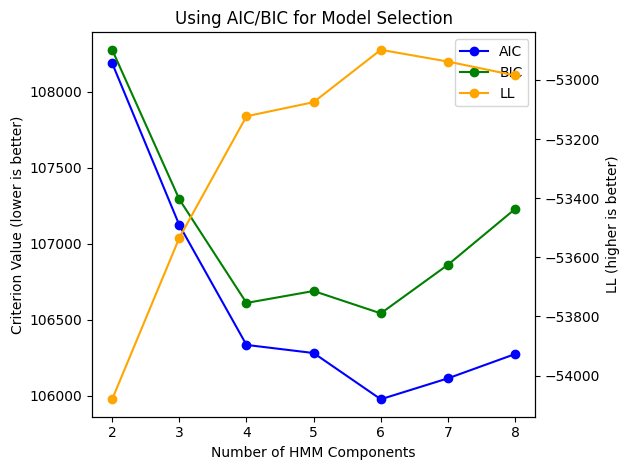

In [11]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

So num of components = 6 contributing the best model.

#### III. Fitting and evaluating

In [5]:
gen_model = hmm.GaussianHMM(n_components = 4, init_params="")
gen_model.n_features = 1
gen_model.startprob_ =  np.array([0.35, 0.3, 0.22, 0.13])
gen_model.transmat_ = np.array([[0.4, 0.3, 0.2, 0.1],
                            [0.3, 0.4, 0.2, 0.1],
                            [0.2, 0.3, 0.4, 0.1],
                            [0.1, 0.2, 0.3, 0.4]])
gen_model.means_ = np.array([[200000],
                        [800000],
                        [1000000],
                        [3000000]])
gen_model.covars_ = np.array([[70000],
                          [210000],
                          [300000],
                          [1000000]])
gen_model.score(X_val.reshape(-1,1), lengths= lengths_val)

-34832.5125697186

In [6]:
n_fits = 20
for i in range(n_fits):
    best_ll = None
    best_model = None
    final_model = hmm.GaussianHMM(n_components= 6)
    final_model.n_features = 1
    final_model.fit(X_train, lengths_train)
    score = final_model.score(X_val.reshape(-1,1), lengths_val)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model = final_model
print('best ll ', best_ll)
    

best ll  -52783.0588329505


In [17]:
print('parameters of best model')
print('model transmat',best_model.transmat_)
print('model start proba', best_model.startprob_)
print('model means', best_model.means_)
print('model covars', best_model.covars_)

parameters of best model
model transmat [[2.21068741e-05 1.71018435e-03 5.84408022e-01 2.42626625e-01
  7.78318887e-10 1.71233061e-01]
 [1.23489287e-01 4.11214953e-01 2.36197980e-02 2.41503515e-01
  1.64575334e-01 3.55971133e-02]
 [8.68280953e-01 1.23430916e-08 1.68121149e-04 7.52017471e-02
  2.84187334e-02 2.79304331e-02]
 [3.41902695e-02 1.82317983e-03 5.32064728e-06 6.68743226e-01
  1.13333233e-01 1.81904771e-01]
 [5.93013223e-01 3.08044544e-01 9.80903646e-02 1.18965148e-06
  2.67091066e-04 5.83587221e-04]
 [5.45479980e-02 4.09541542e-01 1.65931256e-01 2.36153080e-05
  5.55987312e-05 3.69899990e-01]]
model start proba [0.63178579 0.13       0.00516752 0.09115264 0.07953353 0.06236051]
model means [[ 539803.28910617]
 [2999991.58868694]
 [ 507757.59460965]
 [ 903119.76730801]
 [ 899374.62390656]
 [ 528501.80857669]]
model covars [[[1.19689450e+11]]

 [[9.96062363e+05]]

 [[1.16592058e+11]]

 [[9.99602451e+09]]

 [[1.00077045e+10]]

 [[1.17995271e+11]]]


#### IV. Fraud detection

In [7]:
list_fraud

[10, 20, 30, 40, 50, 60, 70]

Text(0.5, 1.0, 'List of fraud transaction (actual)')

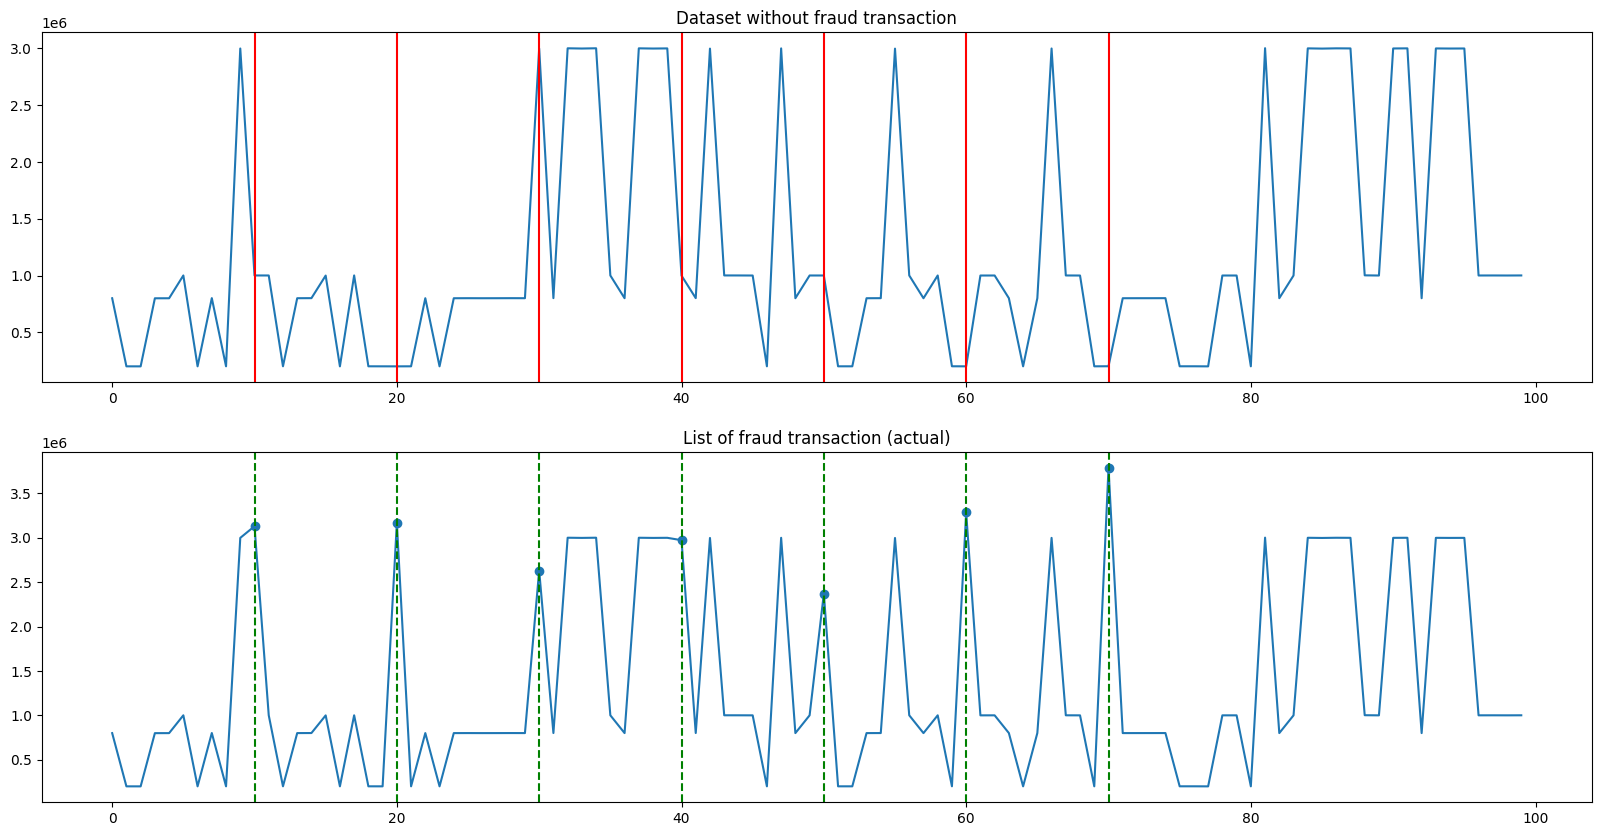

In [51]:
fig, axes = plt.subplots(2,1, figsize = (20,10))
axes[0].plot(X_validate)
axes[1].plot(X_test, markevery = list_fraud, marker = 'o')
for i in list_fraud:
    axes[0].axvline(x = i, color = 'r')
    axes[1].axvline(x = i, color = 'g', linestyle = '--')
axes[0].set_title('Dataset without fraud transaction')
axes[1].set_title('List of fraud transaction (actual)')

In [35]:
X_test_new = X_test.copy()
for n in range(4,9):
    list_detect = []
    for i in range(n,len(X_test)):
        pro_val = np.exp(best_model.score(X_test[i-n:i].reshape(-1,1), lengths = n))
        pro_test = np.exp(best_model.score(X_test[i-n+1:i+1].reshape(-1,1), lengths = n))
        if (pro_val - pro_test)/pro_val * 100 > 99:
            list_detect.append(i)
    print(f'if a sequence contains  {n} obs, list_detect is',list_detect)



if a sequence contains  4 obs, list_detect is [10, 20, 30, 40, 41, 50, 60, 70]
if a sequence contains  5 obs, list_detect is [10, 20, 30, 40, 50, 60, 70]
if a sequence contains  6 obs, list_detect is [10, 20, 30, 40, 50, 60, 70, 92, 96]
if a sequence contains  7 obs, list_detect is [10, 20, 30, 40, 50, 60, 70, 92, 97]
if a sequence contains  8 obs, list_detect is [10, 20, 30, 40, 41, 46, 50, 60, 70, 92, 98]


So if n_components = 6, with num of obs is 5 in a sequence, we can detect all of fraud transaction.

In [43]:
list_detect_final = []
n = 5
for i in range(n,len(X_test)):
    pro_val = np.exp(best_model.score(X_test[i-n:i].reshape(-1,1), lengths = n))
    pro_test = np.exp(best_model.score(X_test[i-n+1:i+1].reshape(-1,1), lengths = n))
    if (pro_val - pro_test)/pro_val * 100 > 99:
        list_detect_final.append(i)

Text(0.5, 1.0, 'List of fraud transaction (actual)')

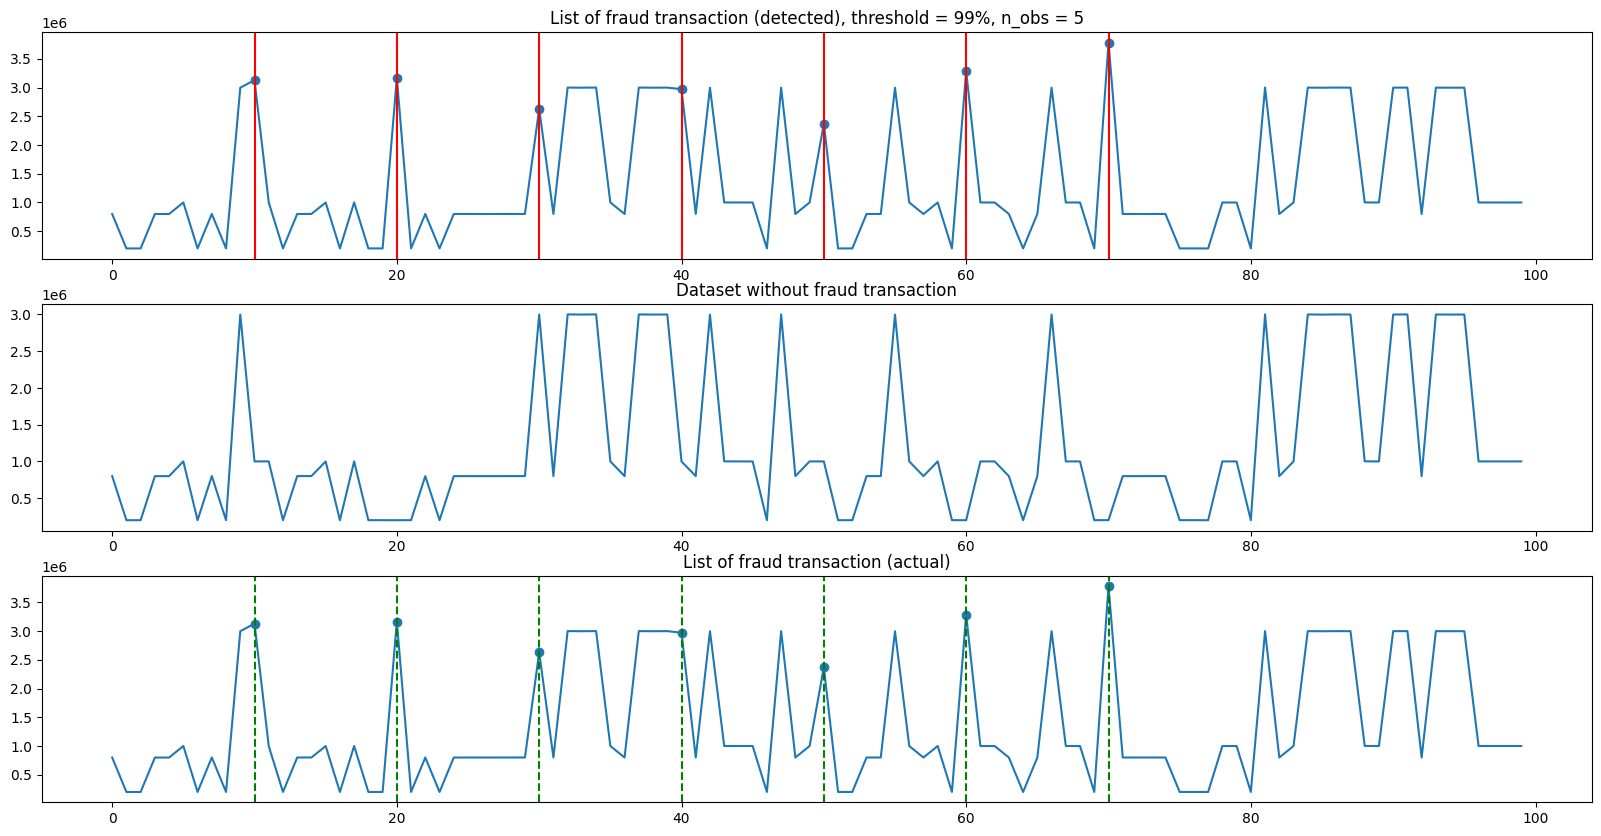

In [50]:
fig, axes = plt.subplots(3,1, figsize = (20,10))
axes[0].plot(X_test, markevery = list_detect_final, marker = 'o')
axes[1].plot(X_validate)
axes[2].plot(X_test, markevery = list_fraud, marker = 'o')
for i in list_fraud:
    axes[0].axvline(x = i, color = 'r')
    axes[2].axvline(x = i, color = 'g', linestyle = '--')
axes[0].set_title('List of fraud transaction (detected), threshold = 99%, n_obs = 5')
axes[1].set_title('Dataset without fraud transaction')
axes[2].set_title('List of fraud transaction (actual)')